# Carregando dataset

In [1]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
# PICKLE_PATH = 'Sunnybrook_Dataset/pickled_data/'
PICKLE_PATH = 'pickle/'

In [2]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

def pre_processamento(img):
    img1=np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_cs = clahe.apply(img1)
    return img_cs

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [3]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)


all_scans = list(map(pre_processamento, all_scans))
all_scans = list(map(converter_pixel_array_rgb, all_scans))

all_scans = np.array(all_scans)
# all_contours = np.array(all_contours)
all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)
# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)


# # converter para float
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

In [4]:
len(X_train), len(X_test), len(X_val)

(563, 161, 81)

In [5]:
Y_train.shape

(563, 256, 256, 1)

In [6]:
len(X_train)

563

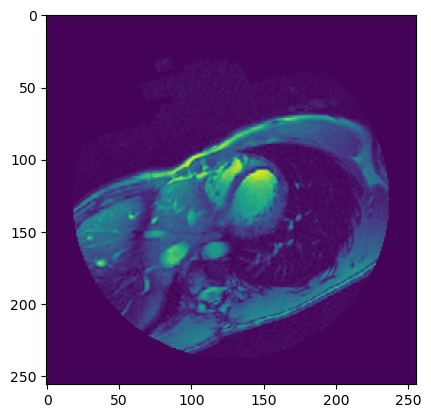

In [7]:
# print(Y_train[0][0])
plt.imshow(X_train[0])
plt.show()

In [8]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.5,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

# Metricas

In [9]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [10]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [11]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       dropout[0][0]                    
______________________________________________________________________________________________

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_for_test.h5', verbose=1, save_best_only=True)

callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [14]:
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=100,callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)

Epoch 1/100
56/56 [==============================] - 56s 590ms/step - loss: 2.3599 - accuracy: 0.9701 - dicemon: 0.0124 - jaccardmon: 0.0063 - val_loss: 0.1365 - val_accuracy: 0.9736 - val_dicemon: 0.0085 - val_jaccardmon: 0.0043
Epoch 2/100
56/56 [==============================] - 28s 489ms/step - loss: 0.0914 - accuracy: 0.9779 - dicemon: 0.0557 - jaccardmon: 0.0292 - val_loss: 0.2506 - val_accuracy: 0.9599 - val_dicemon: 0.0825 - val_jaccardmon: 0.0435
Epoch 3/100
56/56 [==============================] - 28s 490ms/step - loss: 0.0919 - accuracy: 0.9758 - dicemon: 0.0890 - jaccardmon: 0.0481 - val_loss: 0.0540 - val_accuracy: 0.9742 - val_dicemon: 0.2796 - val_jaccardmon: 0.1671
Epoch 4/100
56/56 [==============================] - 28s 493ms/step - loss: 0.0511 - accuracy: 0.9783 - dicemon: 0.2486 - jaccardmon: 0.1472 - val_loss: 0.0450 - val_accuracy: 0.9809 - val_dicemon: 0.3093 - val_jaccardmon: 0.1901
Epoch 5/100
56/56 [==============================] - 28s 505ms/step - loss: 0.04

56/56 [==============================] - 28s 493ms/step - loss: 0.0079 - accuracy: 0.9954 - dicemon: 0.8278 - jaccardmon: 0.7293 - val_loss: 0.0094 - val_accuracy: 0.9946 - val_dicemon: 0.8223 - val_jaccardmon: 0.7225
Epoch 72/100
56/56 [==============================] - 28s 492ms/step - loss: 0.0092 - accuracy: 0.9948 - dicemon: 0.8102 - jaccardmon: 0.7078 - val_loss: 0.0071 - val_accuracy: 0.9956 - val_dicemon: 0.8337 - val_jaccardmon: 0.7327
Epoch 73/100
56/56 [==============================] - 28s 496ms/step - loss: 0.0088 - accuracy: 0.9950 - dicemon: 0.8222 - jaccardmon: 0.7222 - val_loss: 0.0068 - val_accuracy: 0.9957 - val_dicemon: 0.8452 - val_jaccardmon: 0.7486
Epoch 74/100
56/56 [==============================] - 28s 496ms/step - loss: 0.0071 - accuracy: 0.9957 - dicemon: 0.8369 - jaccardmon: 0.7402 - val_loss: 0.0072 - val_accuracy: 0.9955 - val_dicemon: 0.8356 - val_jaccardmon: 0.7393
Epoch 75/100
56/56 [==============================] - 28s 497ms/step - loss: 0.0076 - acc

In [15]:
print(results.history.keys())
model.evaluate(X_train, Y_train)

dict_keys(['loss', 'accuracy', 'dicemon', 'jaccardmon', 'val_loss', 'val_accuracy', 'val_dicemon', 'val_jaccardmon'])
18/18 [==============================] - 28s 807ms/step - loss: 0.0056 - accuracy: 0.9976 - dicemon: 0.8705 - jaccardmon: 0.7845


[0.005641126539558172,
 0.9976131319999695,
 0.8705253601074219,
 0.7845341563224792]

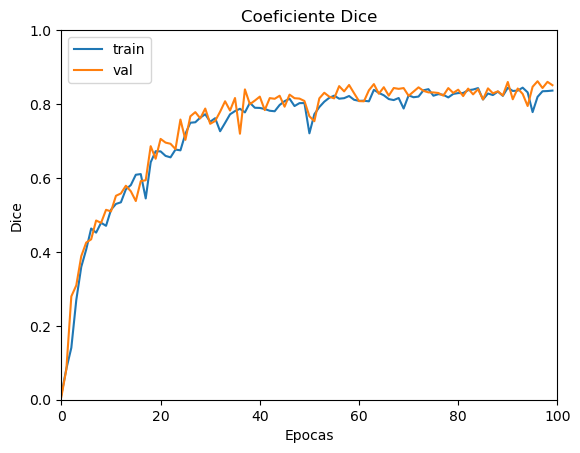

In [16]:
plt.plot(results.history['dicemon'])
plt.plot(results.history['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Epocas')
plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

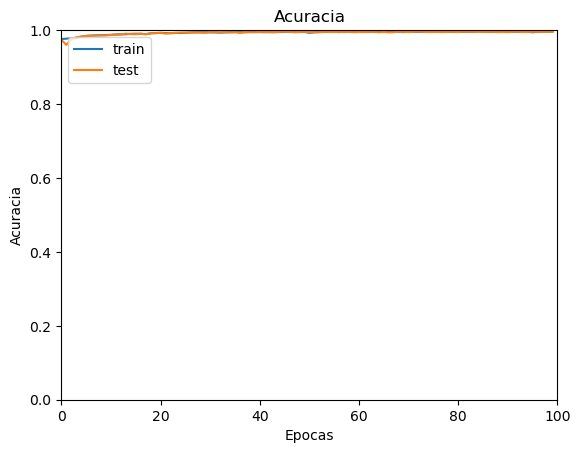

In [17]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Acuracia')

plt.ylabel('Acuracia')
plt.xlabel('Epocas')
plt.axis([0, 100, 0, 1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
predict_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 3s 352ms/step


indice =  46


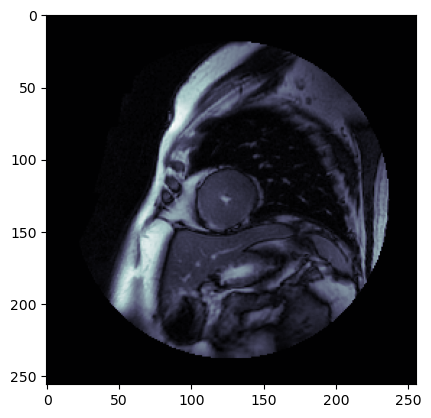

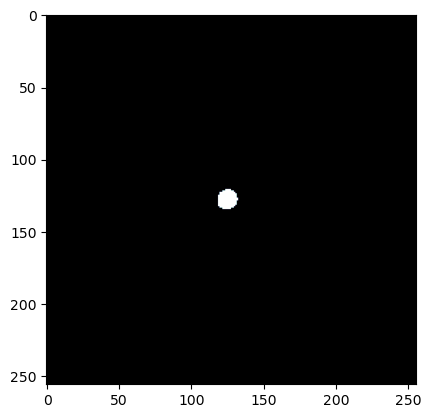

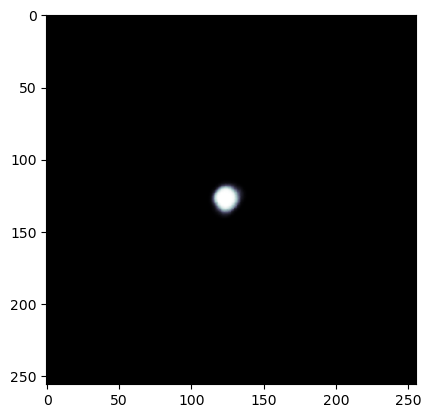

In [19]:
# Ver exemplos de imagens
exemplo = random.randint(0, 160)
print("indice = ", exemplo)

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


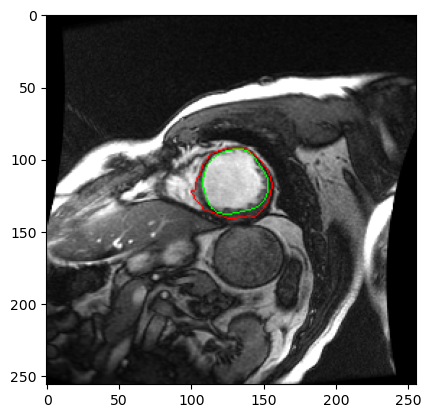

In [57]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = img_as_ubyte(mask)
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img2 = mascara[ind]   
    img3 = add_mascara(img1, img2, (0, 255, 0))
    
    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

dicom = X_test[exemplo]
mascara_gt = Y_test[exemplo]
mascara_p = predict_test[exemplo]

dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_val[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_val[0], cmap=plt.cm.bone)
plt.show()